# 02 - Bomb cyclone case study

In [1]:
# Import libraries and functions
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import xarray as xr
import pandas as pd

from qartod_testing.local_qc_test import load_gross_range_qartod_test_values, load_climatology_qartod_test_values
from ooi_data_explorations.common import m2m_request, m2m_collect

### Plot barometric pressure during bomb cyclone

In [2]:
# Set refdes and other data stream parameters
refdes = 'CP01CNSM-SBD11-06-METBKA000'
site, node, sensor = refdes.split('-',2)
method = 'recovered_host'
stream = 'metbk_hourly'
deploy = 14

In [3]:
# Import async data request dict from text file saved in notebook 01
file = f"../data/external/{refdes}_{method}_{stream}_asyncm2m.txt"
with open(file) as f:
    data = eval(f.read())

In [4]:
# Load data from thredds catalog via M2M API
cnsm_metbk = m2m_collect(data, tag=('.*deployment%04d.*\.nc$' % deploy))

In [11]:
# Make barometric pressure and QARTOD results flag variables for 
# the same time period as the abstract figure
atm_pres = cnsm_metbk["barometric_pressure"].sel(time=slice('2021-10-21','2021-10-31'))
atm_pres_flag = cnsm_metbk["barometric_pressure_qartod_results"].sel(time=slice('2021-10-21','2021-10-31'))

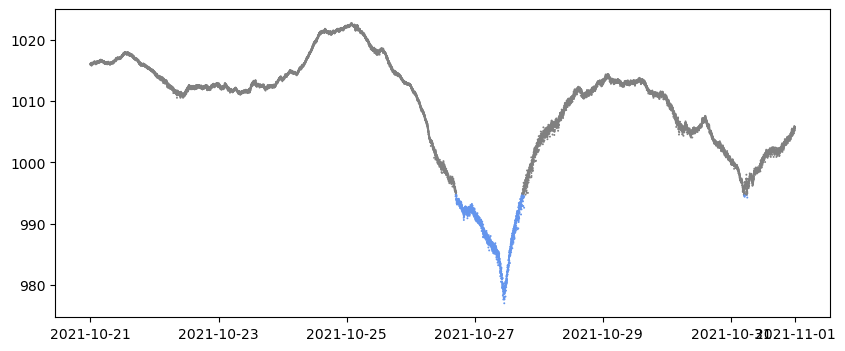

In [12]:
# Recreate figure from notebook 01
plt.figure(figsize=(10,4))
plt.scatter(atm_pres['time'], atm_pres.values, s=2, edgecolors='none',
            c=atm_pres_flag.values, cmap=ListedColormap(['gray', 'cornflowerblue']))

In [5]:
# Create shorter dataset during bomb cyclone
cnsm_cyclone = cnsm_metbk.sel(time=slice('2021-10-21','2021-10-31'))

Since we are using the metbk_hourly data stream, no burst averaging will be needed in this notebook.

In [6]:
# Create function to make plots with color from QARTOD flag result
def color_by_flag(ds, parameter, ax=None, fig=None):
    """ from dataset and parameter name string
    plot a timeseries of the named parameter and 
    color data points based on the corresponding QARTOD
    flag in the relevant _qartod_result parameter in
    the dataset.
    To-do: (maybe not if providing axes works better) 
    if parameter is a list-type, create subplots
    for each of the listed parameters
    Kylene M Cooley
    Version 1 Feb 2024
    
    Inputs:
    -------
    ds, xarray dataset
    parameter, string
    ax, optional matplotlib axes object
    fig, required if ax is provided
    
    Returns:
    --------
    fig, matplotlib figure object
    ax, matplotlib axes object
    """
    # Create data arrays to plot/color points
    da_plot = ds[parameter]
    da_color = ds[f"{parameter}_qartod_results"]
    
    # Create new axes object if none provided
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=(8,3), layout="tight")
    
    # Plot data points in scatter plot
    ax.scatter(da_plot['time'].where(da_color==1), da_plot.where(da_color==1), s=2, edgecolors='none',
            c='black', label="pass")
    ax.scatter(da_plot['time'].where(da_color==2), da_plot.where(da_color==2), s=2, edgecolors='none',
            c='gray', label="not evaluated")
    ax.scatter(da_plot['time'].where(da_color==3), da_plot.where(da_color==3), s=2, edgecolors='none',
            c='green', label="of interest")
    ax.scatter(da_plot['time'].where(da_color==4), da_plot.where(da_color==4), s=2, edgecolors='none',
            c='red', label="fail")
    plt.legend(markerscale=4)
    plt.grid()
    return fig, ax

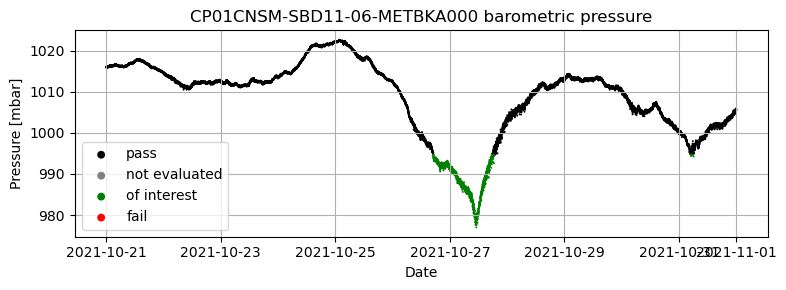

In [7]:
# Plot barometric pressure with new function
fig, ax = color_by_flag(cnsm_cyclone, "barometric_pressure")
plt.title(f"{refdes} barometric pressure")
plt.xlabel("Date")
plt.ylabel("Pressure [mbar]")
plt.show()

### Plot other METBK parameters during the same time period

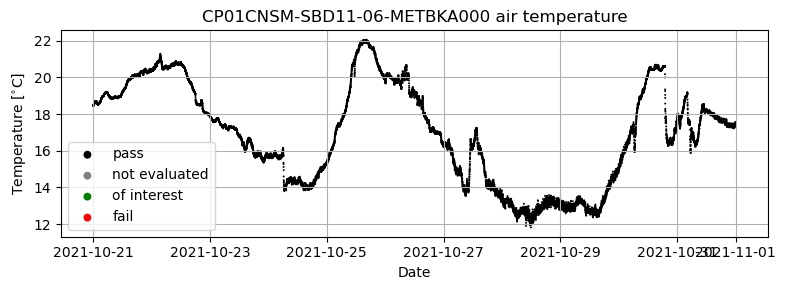

In [30]:
# Plot air temperature during bomb cyclone with data point color from the QARTOD flag
fig, ax = color_by_flag(cnsm_metbk, "air_temperature")
plt.title(f"{refdes} air temperature")
plt.xlabel("Date")
plt.ylabel("Temperature [$^{\circ}$C]")
plt.show()

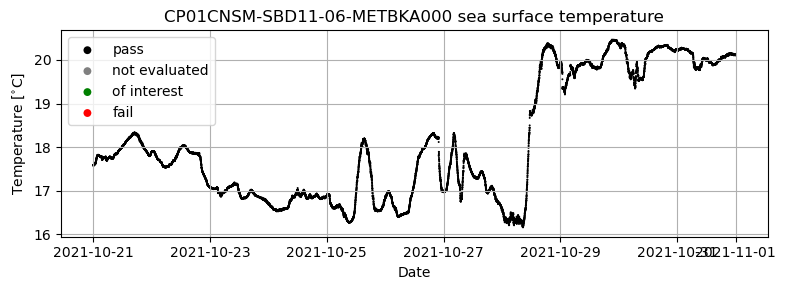

In [31]:
# Plot SST from deployment 14 with data point color from the QARTOD flag
fig, ax = color_by_flag(cnsm_metbk, "sea_surface_temperature")
plt.title(f"{refdes} sea surface temperature")
plt.xlabel("Date")
plt.ylabel("Temperature [$^{\circ}$C]")
plt.show()

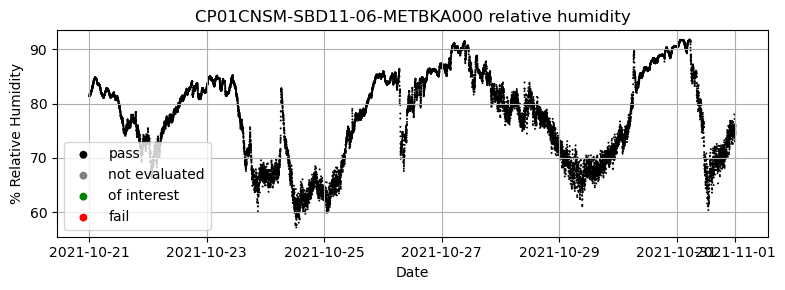

In [34]:
# Plot relative humidity from deployment 14 with data point color from the QARTOD flag
fig, ax = color_by_flag(cnsm_metbk, "relative_humidity")
plt.title(f"{refdes} relative humidity")
plt.xlabel("Date")
plt.ylabel("% Relative Humidity")
ax.legend(loc="lower left", markerscale=4)
plt.show()

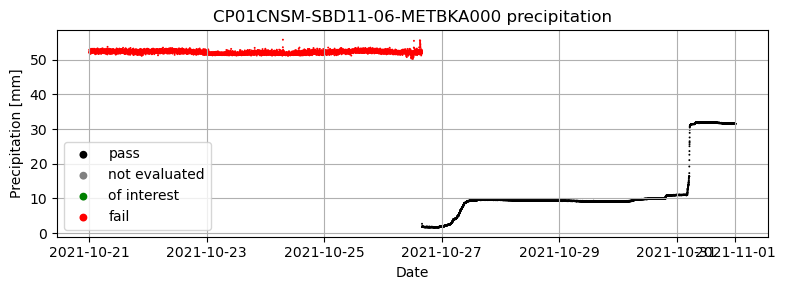

In [35]:
# Plot precipitation from deployment 14 with data point color from the QARTOD flag
fig, ax = color_by_flag(cnsm_metbk, "precipitation")
plt.title(f"{refdes} precipitation")
plt.xlabel("Date")
plt.ylabel("Precipitation [mm]")
plt.show()

It is unclear just from looking at the above timeseries, but perhaps the precipitation sensor was saturated until the onset of the bomb cyclone.

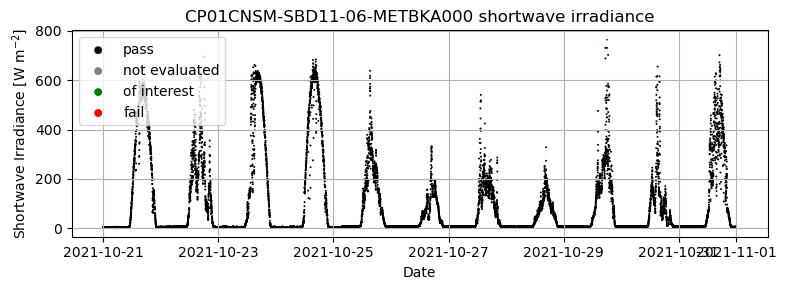

In [38]:
# Plot shortwave irradiance from deployment 14 with data point color from the QARTOD flag
fig, ax = color_by_flag(cnsm_metbk, "shortwave_irradiance")
plt.title(f"{refdes} shortwave irradiance")
plt.xlabel("Date")
plt.ylabel("Shortwave Irradiance [W m$^{-2}$]")
ax.legend(loc="upper left", markerscale=4)
plt.show()

### Compare CNSM barometric pressure to other surface moorings

In [8]:
# Set offshore surface mooring refdes and other data stream parameters
ossm_refdes = 'CP04OSSM-SBD11-06-METBKA000'
site, node, sensor = ossm_refdes.split('-',2)

In [ ]:
# Make asynchronous M2M request
ossm_data = m2m_request(site, node, sensor, method, stream)

In [42]:
# Write asynchronous data request dict to a text file
with open(f"../data/external/{refdes}_{method}_{stream}_asyncm2m.txt", 'w') as text_file:
    text_file.write(str(ossm_data))

In [10]:
# Set inshore surface mooring refdes and other data stream parameters
issm_refdes = 'CP03ISSM-SBD11-06-METBKA000'
site, node, sensor = refdes.split('-',2)

In [44]:
# Make asynchronous M2M request
issm_data = m2m_request(site, node, sensor, method, stream)

Requesting:
	refdes: CP03ISSM-SBD11-06-METBKA000
	method: recovered_host
	stream: metbk_hourly
	from None to None
Waiting for OOINet to process and prepare data request, this may take up to 20 minutes.
Waiting: 100%|██████████| 400/400 [20:04<00:00,  3.01s/it]


In [45]:
# Write asynchronous data request dict to a text file
with open(f"../data/external/{refdes}_{method}_{stream}_asyncm2m.txt", 'w') as text_file:
    text_file.write(str(issm_data))

In [11]:
# Import async data request dict from saved text files
file = f"../data/external/{ossm_refdes}_{method}_{stream}_asyncm2m.txt"
with open(file) as f:
    ossm_data = eval(f.read())

file = f"../data/external/{issm_refdes}_{method}_{stream}_asyncm2m.txt"
with open(file) as f:
    issm_data = eval(f.read())

In [12]:
# Load data from OSSM and ISSM from async requests
# ossm_metbk = m2m_collect(ossm_data, tag=('.*deployment%04d.*\.nc$' % deploy))
ossm_metbk = m2m_collect(ossm_data, tag=('.*deployment%03d.*\.nc$' % 1))
issm_metbk = m2m_collect(issm_data, tag=('.*deployment%03d.*\.nc$' % 1))

In [22]:
# Create subsets of datasets for the bomb cyclone and surrounding days
ossm_cyclone = ossm_metbk.sel(time=slice('2021-10-21','2021-10-31'))
issm_cyclone = issm_metbk.sel(time=slice('2021-10-21','2021-10-31'))

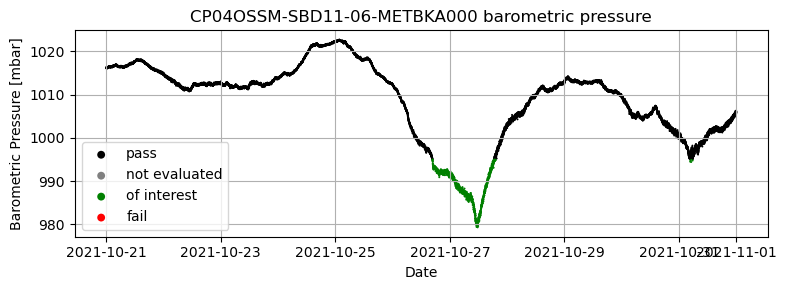

In [23]:
# Plot pressure during bomb cyclone from OSSM
fig, ax = color_by_flag(ossm_cyclone, "barometric_pressure")
plt.title("CP04OSSM-SBD11-06-METBKA000 barometric pressure")
plt.xlabel("Date")
plt.ylabel("Barometric Pressure [mbar]")
# ax.legend(loc="upper left", markerscale=4)
plt.show()

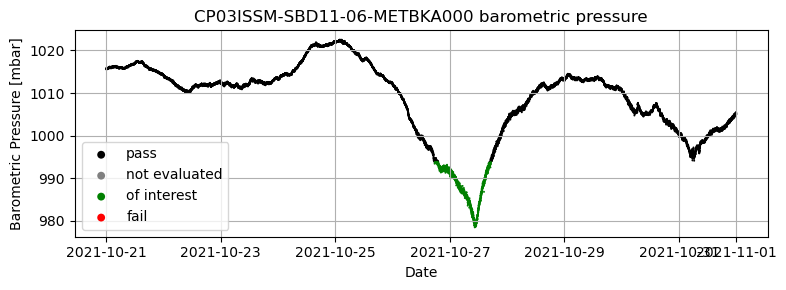

In [24]:
# Plot pressure during bomb cylone and surrounding days
fig, ax = color_by_flag(issm_cyclone, "barometric_pressure")
plt.title("CP03ISSM-SBD11-06-METBKA000 barometric pressure")
plt.xlabel("Date")
plt.ylabel("Barometric Pressure [mbar]")
# ax.legend(loc="upper left", markerscale=4)
plt.show()

In [ ]:
# Plot all 3 cyclone time series on same axes